# <center>Read Keystroke Data and Build Model to Process</center>

In [1]:
import os
import copy
import string
import csv
import random
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.mixture import GMM
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedKFold

input_path = "Dataset/Kevin and Maxion/DSL-StrongPasswordData.csv"
print input_path;

Dataset/Kevin and Maxion/DSL-StrongPasswordData.csv


## Import Raw Data and Extract Features. Pre-process the data 

### Data Normalization
* From the begining, I think data here doesn't need to be normalized. Because the range of the value is small, and features' value is close to each other.
* In order to improve the accuracy of the model, we'd better try whether the normalization can bring us some improvement.

In [2]:
## Z-score normalization
def normalize(data, mean, std):
    num_col = len(data[0]);
    num_row = len(data);

    for j in range(num_col):
        for i in range(num_row):
            data[i][j] = (data[i][j] - mean[j])/std[j];
            
    return data;

## split data to train_data and test_data for cross validation
def pre_process(data, fold, shuffle):

    kf = cross_validation.KFold(len(data), n_folds=fold, shuffle=shuffle);
    print kf;
    train_index, test_index = next(iter(kf));
    train, test = data[train_index], data[test_index];
        
    train_targets = train[:, 0:1].ravel();
    train_features = train[:, 3:];
    test_targets = test[:, 0:1].ravel();
    test_features = test[:, 3:];
            
    return train_targets, train_features, test_targets, test_features;

### Dataset (The CMU keystroke dynamics dataset)

* The CMU benchmark dataset contains keystroke dynamics consisting of the dwell time for each key and the latencies between two successive keys for static password string “.tie5Roanl”.
* For each subject, there were data collection sessions with at least one day apart between two sessions. 50 repeated keystroke strings were collected in each session, resulting in a total 400 sample for each subject.
* For each typed 10-letter password and the final enter key, the dwell time and diagraphs give rise to a 31 dimensional feature vector.

Although the keystroke features provide sufficiently distinguishing patterns for each subject, they are highly correlated, with large scale variations, and typical of noise and outliers. Someone has previously proposed a new distance metric to effectively handle these challenges that are intrinsic to keystroke dynamics data.

* Make imposter set: The first 5 samples from the whole 51 subjects. When we choose imposters for one user, we use the remaining 50 subjects as negative test data.

In [3]:
file = open(input_path, "r");

raw_data = file.read();
print type(raw_data);

file.close();

data_lines = np.array(raw_data.splitlines());
print data_lines[0];

data = np.array([x.split(",") for x in data_lines]);
# data = np.delete(data, np.s_[31:34], 1); ## Delete the "Enter"'s information
data = np.delete(data, np.s_[31::1], 1);
data = np.delete(data, 0, 0); ## Delete the first line
num_feature = len(data[0])-3;

# change username to index (0-50)
for i in range(len(data)):
    data[i][0] = i/400;

data = data.astype(np.float);

## data normalization (z-score)
global_Mean, global_Std = [], []; ##record the mean and std for each feature over the whole dataset 
for i in range(num_feature):
    global_Mean.append(np.mean(data[:, 3+i]));
    global_Std.append(np.std(data[:, 3+i]));

data[:, 3:] = normalize(data[:, 3:], global_Mean, global_Std);

data_two = data[0:2*400];
data_user = np.array([data[i*400:(i+1)*400] for i in range(51)]);

print "Data: ", data.shape;
print "Data per user: ", data_user.shape; ## All the data organized by different users

## build imposter pool
## For each user, random choose 100 samples as imposter
imposter_size_per_user = 50;
imposterIndex = [random.randrange(0, 400, 5) for i in range(imposter_size_per_user)];
imposter = np.array([data_user[i][imposterIndex] for i in range(0,51)]);
# imposter = np.array([data_user[i][0:5] for i in range(0, 51)]);

print "Imposter: ", imposter.shape;
imposter_targets = imposter[:, :, 0];
imposter_features = imposter[:, :, 3:];
print "Imposter features: ", imposter_features.shape;
imposter_size = len(imposter)*imposter_size_per_user;

## Add my own data
with open("Dataset/New Users/PUYang.csv", 'r') as file:
    reader = csv.reader(file);
    py_data = np.array([row for row in reader]);
    
print "Personal data: ", py_data.shape;
py_data = np.array(py_data);
py_data = py_data.astype(np.float);

## Data normalization
py_data = normalize(py_data, global_Mean, global_Std);

<type 'str'>
subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,DD.i.e,UD.i.e,H.e,DD.e.five,UD.e.five,H.five,DD.five.Shift.r,UD.five.Shift.r,H.Shift.r,DD.Shift.r.o,UD.Shift.r.o,H.o,DD.o.a,UD.o.a,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
Data:  (20400L, 31L)
Data per user:  (51L, 400L, 31L)
Imposter:  (51L, 50L, 31L)
Imposter features:  (51L, 50L, 28L)
Personal data:  (152L, 28L)


### Build train dataset and test dataset

* Existing works in applying GMM to keystroke authentication is to train a GMM for each genuine user. At testing time, a keystroke feature is evaluated against the genuine user's GMM and a threshold is applied to the likelihood of the feature vector to make the decision.

* The idea of TMM-UBM is to train another GMM from a large pool of so-called background subjects (except the genuine user and the actual testing subjects). When the pool of background subjects is large enough, the UBM will have a good chance to reasonably represent any imposter's data. Thus, the imposter can have a relatively high likelihood score under UBM.

* A key common feature of these algorithms is that an unsupervised training is conducted on a large pool of subjects at the first stage to allow the classifier take advantage of the overall data distribution in the feature space for improved performance.

In [4]:
## pre_process the whole dataset, use cross_validation to divide it into 5 folds
train_target, train_feature, test_target, test_feature = pre_process(data, 5, True); 
## pre_process the first user's data
train_target_user, train_feature_user, test_target_user, test_feature_user = pre_process(data_user[0], 5, True); 
## pre_process the first two user's data
train_target_two, train_feature_two, test_target_two, test_feature_two = pre_process(data_two, 5, True); 

print train_feature_user.shape

subjects = np.unique(train_target);
subjects_two = subjects[0:2];
# n_classes = len(subjects);
# n_classes_two = len(subjects_two);
print subjects;
# print n_classes;

sklearn.cross_validation.KFold(n=20400, n_folds=5, shuffle=True, random_state=None)
sklearn.cross_validation.KFold(n=400, n_folds=5, shuffle=True, random_state=None)
sklearn.cross_validation.KFold(n=800, n_folds=5, shuffle=True, random_state=None)
(320L, 28L)
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.
  45.  46.  47.  48.  49.  50.]


## Gaussian Mixture Models with Universal Background Model
* A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions wih unknown parameters. (Gaussian Distribution = Normal Distribution)
* The GMM object implements the EM algorithm for fitting mixture-of-Gaussian models.
* GMM.fit method learns a Gaussian Mixture Model from train data. Gmm.predict method can assign each sample of test data to the Gaussian class which it mostly probably belong to.
* The GMM has different options to constrain the covariance: spherical, diagonal, tied or full covariance. Since we have class labels for the training data, we can initialize the GMM parameters in a supervised manner.

('spherical', GMM(covariance_type='spherical', init_params='wc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=20, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0))
('Train_accuracy', 86.40625)
('Test_accuracy', 88.75)
(57L, 28L)
(103L, 28L)
('diag', GMM(covariance_type='diag', init_params='wc', min_covar=0.001, n_components=2,
  n_init=1, n_iter=20, params='wmc', random_state=None, thresh=None,
  tol=0.001, verbose=0))
('Train_accuracy', 88.4375)
('Test_accuracy', 90.625)
(70L, 28L)
(90L, 28L)
('full', GMM(covariance_type='full', init_params='wc', min_covar=0.001, n_components=2,
  n_init=1, n_iter=20, params='wmc', random_state=None, thresh=None,
  tol=0.001, verbose=0))
('Train_accuracy', 88.90625)
('Test_accuracy', 88.125)
(74L, 28L)
(86L, 28L)
('tied', GMM(covariance_type='tied', init_params='wc', min_covar=0.001, n_components=2,
  n_init=1, n_iter=20, params='wmc', random_state=None, thresh=None,
  tol=0.001, verbose=0))
('Train_accuracy', 93.75)
('Test

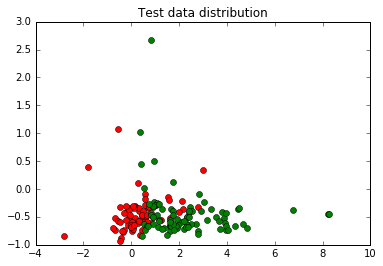

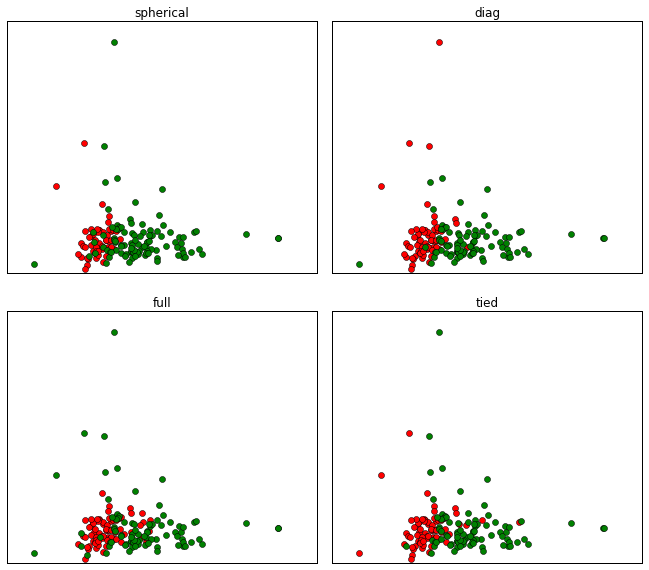

In [7]:
from sklearn.mixture import GMM
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedKFold

#Try GMMs with different types of covariances
# How to find the best n_components
classifiers = dict((covar_type, GMM(n_components=2, covariance_type=covar_type, init_params='wc', n_iter=20)) 
                   for covar_type in ['spherical', 'diag', 'tied', 'full']);

n_classifiers = len(classifiers);

plt.figure(figsize = (6, 4));
for n, color in enumerate('rg'):
    visual = test_feature_two[test_target_two == n];
    plt.plot(visual[:, 0], visual[:, 1], 'o', color=color);
    
plt.title("Test data distribution");

plt.figure(figsize=(3 * n_classifiers * 0.75, 8));
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05, left=.01, right=.99);

for index, (name, clf) in enumerate(classifiers.items()):
    # Since we have class labels for the training data, 
    # we can initialize the GMM parameters in a supervised manner.
    print (name, clf);
    
    clf.means_ = np.array([train_feature_two[train_target_two == user].mean(axis=0) for user in subjects_two]);

    # means_ : array, shape (n_components, n_features) Mean parameters for each mixture component.
    # axis : Axis or axes along which the means are computed. The default is to compute the mean of the flattened array. 
    # If this is a tuple of ints, a mean is performed over multiple axes, instead of a single axis or all the axes as before.
    # Compute the mean of features of every user seperately
    
    # Train the other parameters using the EM algorithm
    clf.fit(train_feature_two);
    
    plt.subplot(2, n_classifiers/2, index+1); # subplot(nrows, ncols, plot_number)
    
    train_pred = clf.predict(train_feature_two);
    test_pred = clf.predict(test_feature_two);
    train_accuracy = np.mean(train_pred == train_target_two)*100;
    test_accuracy = np.mean(test_pred == test_target_two)*100;
    print ("Train_accuracy", train_accuracy);
    print ("Test_accuracy", test_accuracy);

    # Visualization of the result
    for n, color in enumerate('rg'):
        visual_test = test_feature_two[test_pred == n];
        print visual_test.shape;
        plt.plot(visual_test[:,0], visual_test[:,1], 'o', color=color);      
    
    plt.xticks(());
    plt.yticks(());
    plt.title(name);

### Evaluate the cluster's quality with criterion parameters
* aic: Akaike information criterion;  bic: Bayesian information criterion. (the lower the better)

sklearn.cross_validation.KFold(n=400, n_folds=5, shuffle=True, random_state=None)
sklearn.cross_validation.KFold(n=400, n_folds=5, shuffle=True, random_state=None)


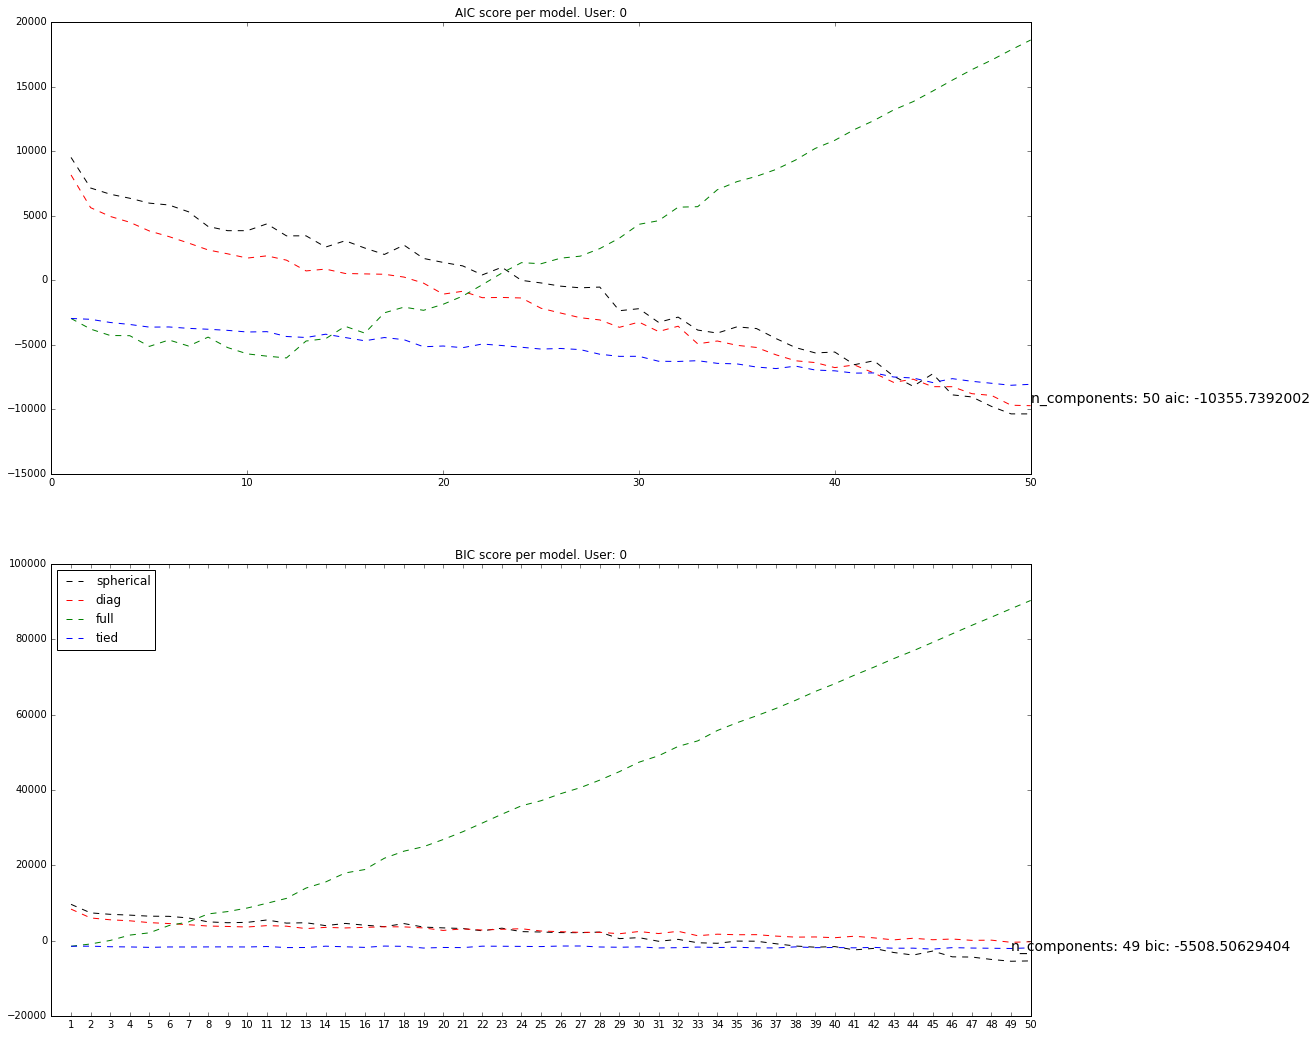

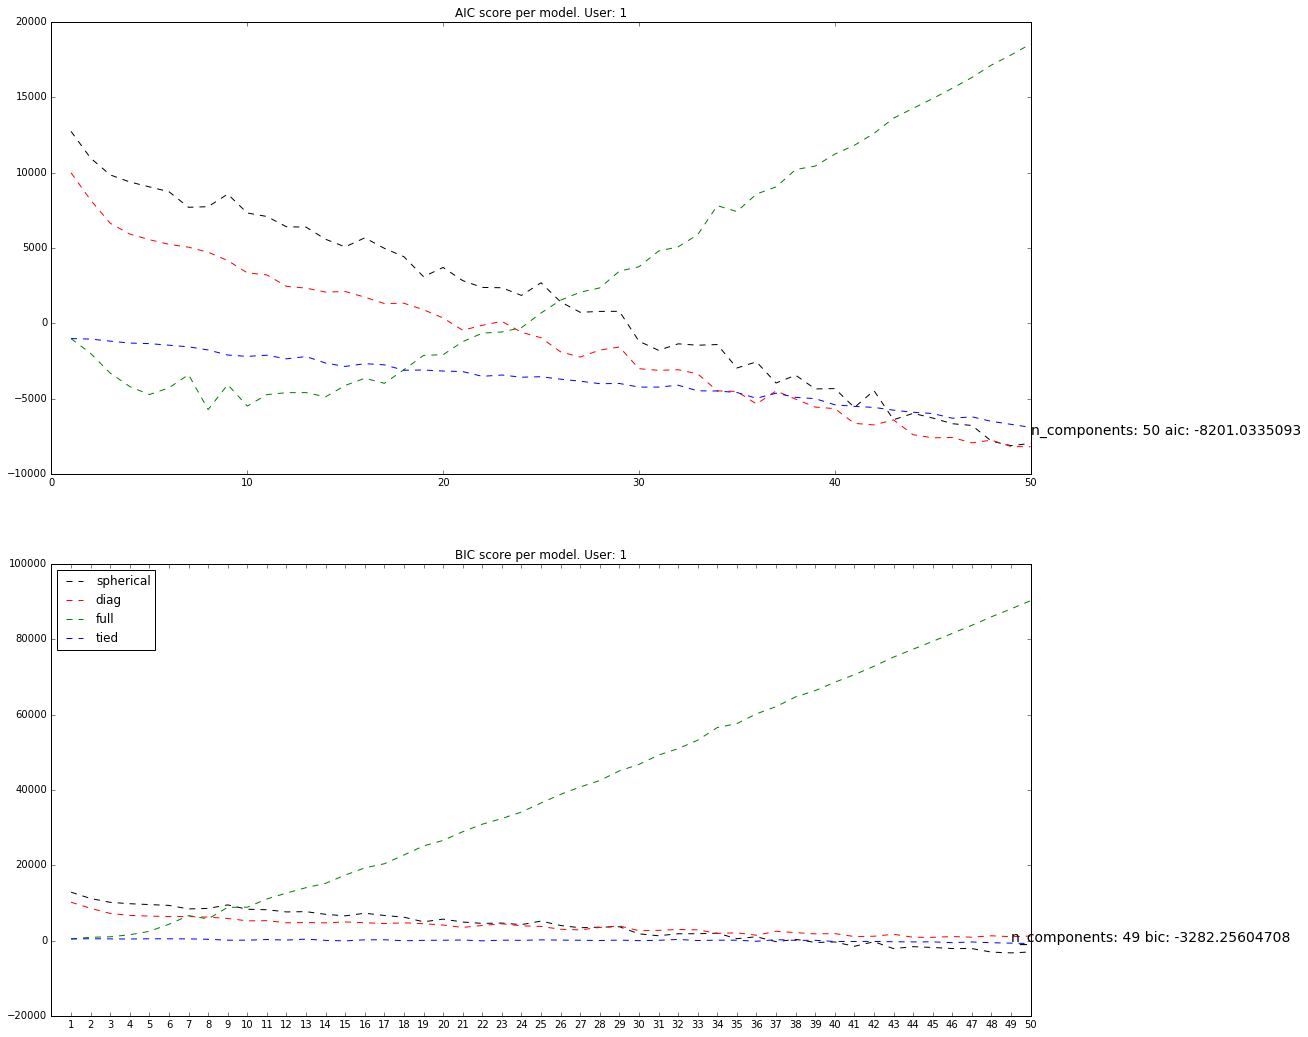

In [9]:
user_range = range(0,2);
n_components_range = range(1, 51); ## range of numcomponents
covariances=['spherical', 'diag', 'full', 'tied'];
color_list = ['k', 'r', 'g', 'b'];

for user_index in user_range:

    trainTarget, trainSet, testTarget, testSet = pre_process(data_user[user_index], 5, True);
    trainIndex = [random.randrange(0, len(trainSet), 3) for i in range(200)];
    trainSet = np.array([trainSet[i] for i in trainIndex]);
    
    plt.figure(figsize=(16, 20));
    spl_1 = plt.subplot(2,1,1);
    plt.title('AIC score per model. User: ' + str(user_index));
    spl_2 = plt.subplot(2,1,2);
    plt.title('BIC score per model. User: ' + str(user_index));
    plt.subplots_adjust(left=0.12, right=0.97, bottom=0.21, top=0.9, wspace=0.2);

    aic_min, bic_min, aic_max, bic_max, index = np.infty, np.infty, -np.infty, -np.infty, 1;
    bars_aic, bars_bic = [], [];

    for index, (covar_type, color) in enumerate(zip(covariances, color_list)):
        AIC, BIC = [], [];
        for num_com in n_components_range:
            gmm = GMM(n_components=num_com, covariance_type=covar_type);
            gmm.fit(trainSet);
            AIC.append(gmm.aic(trainSet));
            BIC.append(gmm.bic(trainSet));

        if aic_min > min(AIC):
            aic_min = min(AIC);
            minpos_aic = AIC.index(aic_min)+1;
            covar_aic = covar_type;
        if bic_min > min(BIC):
            bic_min = min(BIC);
            minpos_bic = BIC.index(bic_min)+1;
            covar_bic = covar_type;
        if aic_max < max(AIC):
            aic_max = max(AIC);
        if bic_max < max(BIC):
            bic_max = max(BIC);

        spl_1.plot(n_components_range, AIC, '--', color=color, label=covar_type);
        spl_2.plot(n_components_range, BIC, '--', color=color, label=covar_type);

    plt.xticks(n_components_range);
    spl_1.text(minpos_aic, aic_min*0.97+.03*aic_max, 'n_components: '+str(minpos_aic)
               + ' aic: ' + str(aic_min), fontsize=14);
    spl_2.text(minpos_bic, bic_min*0.97+.03*bic_max, 'n_components: '+str(minpos_bic)
               + ' bic: ' + str(bic_min), fontsize=14);
    plt.legend(covariances, loc='upper left');


# What has happened is that [[]] is a one-element list containing an empty list, 
# so all three elements of [[]] * 3 are references to this single empty list. 
# Modifying any of the elements of lists will modify this single list.

### Experiment: begin with a small one
* See the curve of the FAR & FRR with variation of K_LOOM under the situation which has defined parameters

sklearn.cross_validation.KFold(n=400, n_folds=2, shuffle=True, random_state=None)


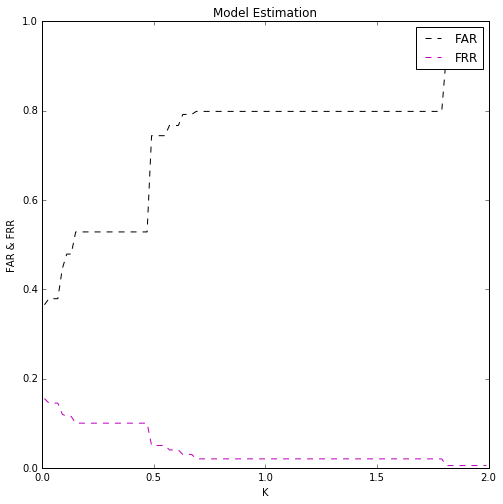

In [28]:
## Small experiment with User2 in CMU dataset
covariances=['spherical', 'diag', 'full', 'tied'];

## Size of train set: 50
trainTarget, trainSet, testTarget, testSet = pre_process(data_user[1], 2, True);
trainIndex = [random.randrange(0, len(trainSet), 3) for i in range(50)];
trainSet = np.array([trainSet[i] for i in trainIndex]);

imposterSet = np.concatenate((imposter_features[0:1], 
                              imposter_features[1+1:])).reshape(imposter_size-imposter_size_per_user, 28);
genuine_user = np.array(testSet);
imposter_user = imposterSet;

profiles = dict((covar_type, GMM(n_components=49, covariance_type=covar_type, init_params='wc', n_iter=20)) 
                   for covar_type in covariances);

model = profiles["diag"]
loo = cross_validation.LeaveOneOut(len(trainSet));
Scores = [];

for train_index, test_index in loo:
    train, test = trainSet[train_index], trainSet[test_index];
    model.fit(train);
    Scores.append(model.score(test));

model.fit(trainSet);
Scores = np.array(Scores).ravel();
mean = np.mean(Scores);
std = np.std(Scores);

scores_imposter = [model.score(imposter_user[i].reshape(1,-1)) for i in range(len(imposter_user))];
scores_genuine = [model.score(genuine_user[i].reshape(1,-1)) for i in range(len(genuine_user))];

#Evalutation of the model
FAR, FRR = [], [];
K_range = np.arange(0.01, 2.01, 0.02)

for K in K_range:
    Seq = [Scores[j] for j in range(len(Scores)) if abs(Scores[j] - mean) < K*std];
    if(not Seq):
        threshold_user = mean - K*std;
    else:
        threshold_user = min(Seq);

    reject, accept = 0, 0;
    for i in range(len(scores_imposter)):
        if(scores_imposter[i] >= threshold_user):
            accept = accept+1;
    
    FAR.append(float(accept)/float(len(scores_imposter)));

    for i in range(len(scores_genuine)):
        if(scores_genuine[i] < threshold_user):
            reject = reject+1;
    
    FRR.append(float(reject)/float(len(scores_genuine)));

plt.figure(figsize=(8,8));
plt.plot(K_range, FAR, '--k', label = "FAR");
plt.plot(K_range, FRR, '--m', label = "FRR");
plt.xlabel("K");
plt.ylabel("FAR & FRR");
plt.title("Model Estimation");
plt.legend(loc='upper right')

### Main Part for the Experiment
* Set the experiment configuration. Evaluate the effectiveness of the model by EER directly.
* Grid search, try to look for the optimal parameters' combination

Processing on User  45
sklearn.cross_validation.KFold(n=400, n_folds=2, shuffle=True, random_state=None)
Size of trainSet:  50
Covar_type:  tied
Time interval:  445.704109857
Covar_type:  diag
Time interval:  37.4817544162
Processing on User  46
sklearn.cross_validation.KFold(n=400, n_folds=2, shuffle=True, random_state=None)
Size of trainSet:  50
Covar_type:  tied
Time interval:  447.824078787
Covar_type:  diag
Time interval:  39.8522322085
Processing on User  47
sklearn.cross_validation.KFold(n=400, n_folds=2, shuffle=True, random_state=None)
Size of trainSet:  50
Covar_type:  tied
Time interval:  473.097101243
Covar_type:  diag
Time interval:  44.3736301058
Processing on User  48
sklearn.cross_validation.KFold(n=400, n_folds=2, shuffle=True, random_state=None)
Size of trainSet:  50
Covar_type:  tied
Time interval:  455.256225668
Covar_type:  diag
Time interval:  38.4472515809
Processing on User  49
sklearn.cross_validation.KFold(n=400, n_folds=2, shuffle=True, random_state=None)
Siz

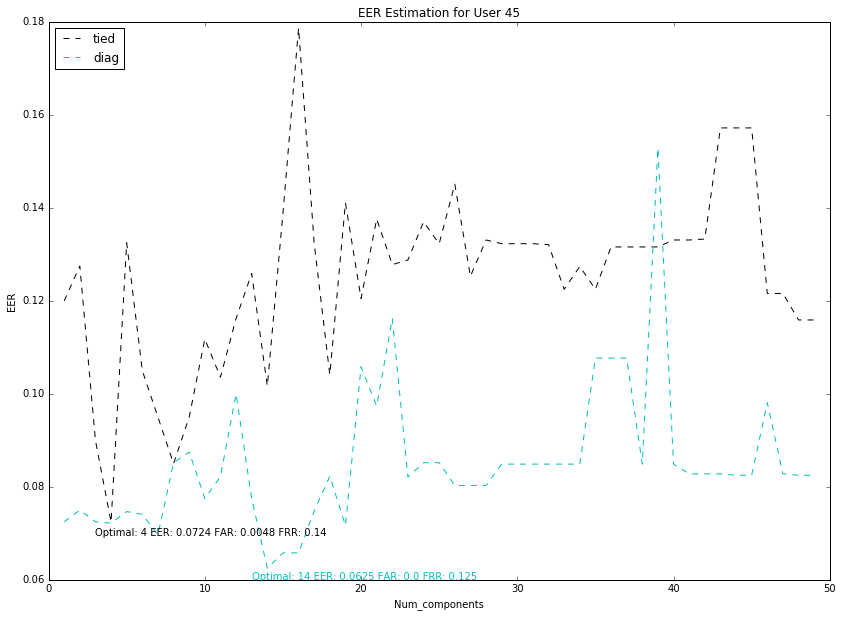

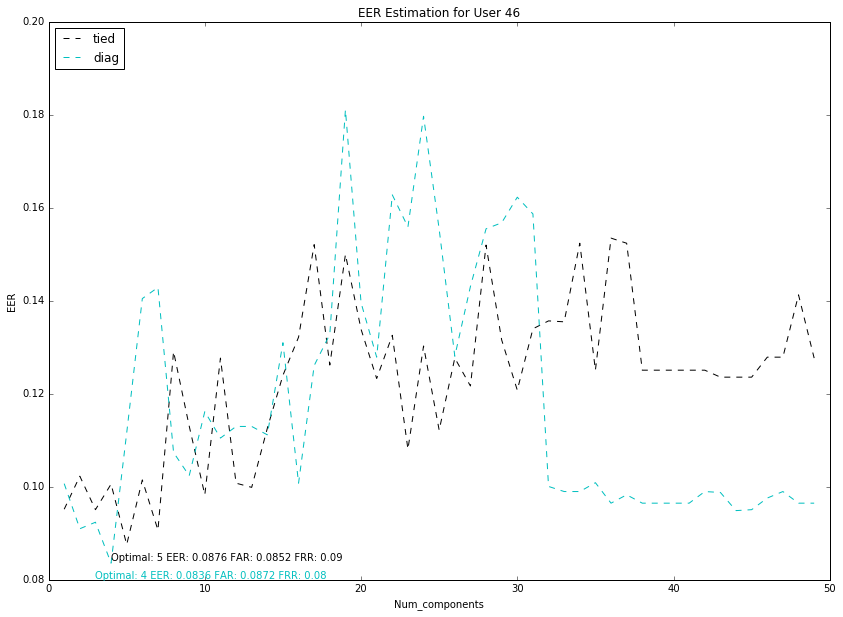

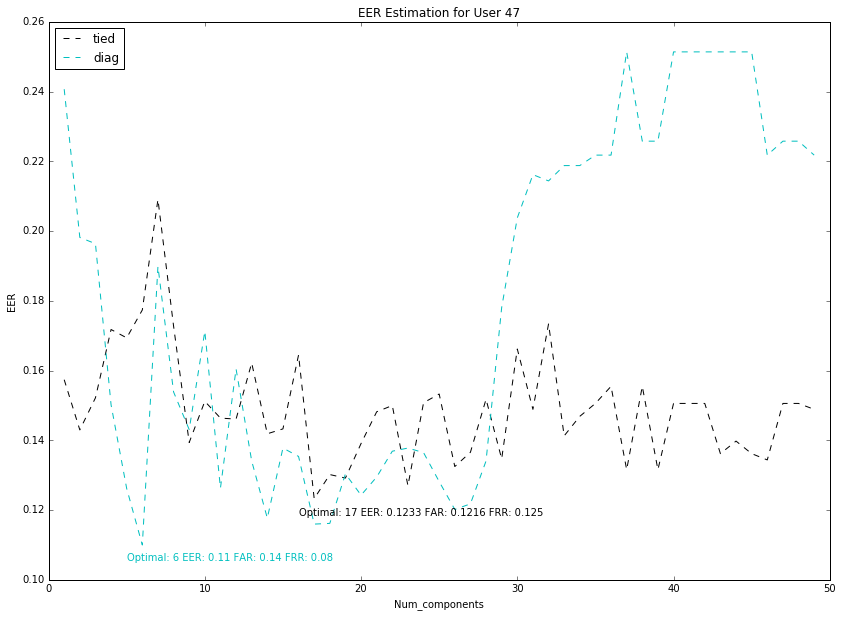

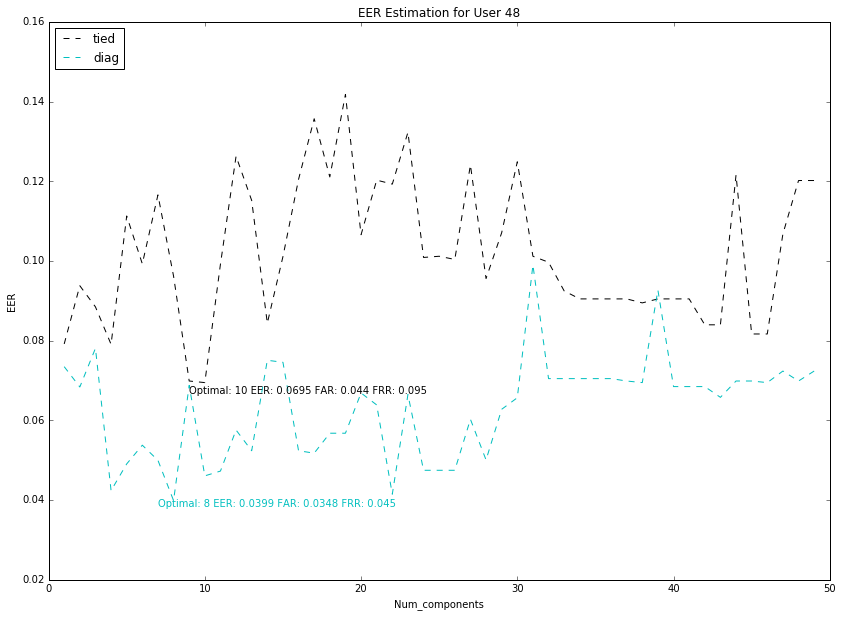

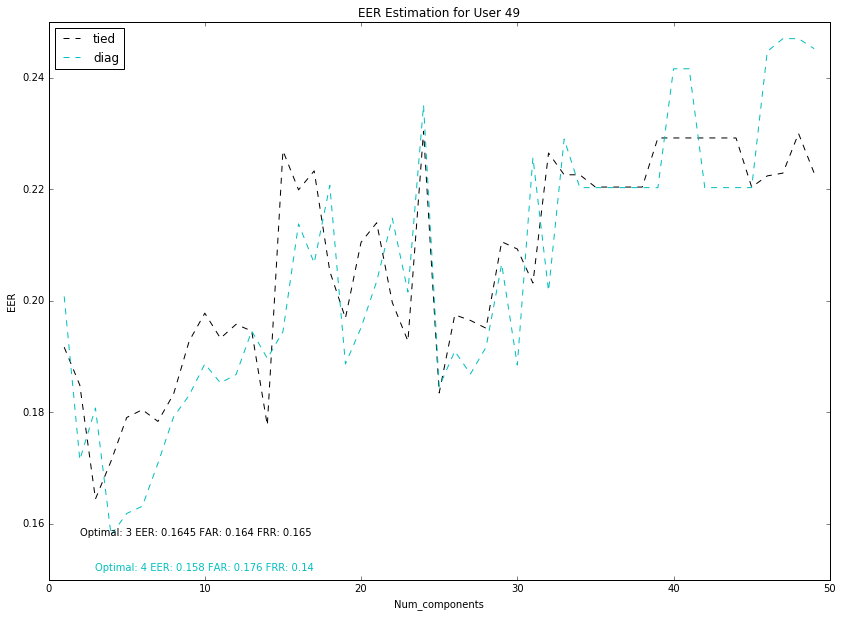

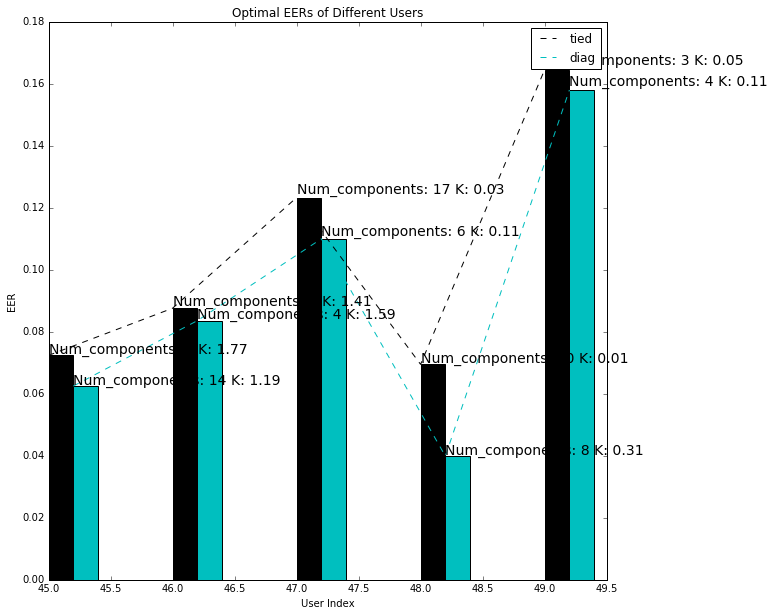

In [25]:
import random;
from time import clock;

user_range = range(45,50) ##  range of user. Totally 51 users
n_components_range = range(1, 50); ## num_components: 1~50
K_range = np.arange(0.01, 2.01, 0.02); ## 0.01~1.99, variance is 0.02
# color_list = ['k', 'c', 'g', 'b'];
# covariances=['spherical', 'diag', 'full', 'tied'];

## For debug
color_list = ['k', 'c'];
covariances = ['tied','diag']; 

Opt_n_components = dict((covar_type, []) for covar_type in covariances);
Opt_EER = dict((covar_type, []) for covar_type in covariances);
Opt_K = dict((covar_type, []) for covar_type in covariances);

#### User Loop
for index_user in user_range: ## Try the first 10 user
    print 'Processing on User ', index_user;
    
    plt.figure(figsize=(14,10)); ## One picture per user
    plt.title("EER Estimation for User " + str(index_user));

    trainTarget, trainSet, testTarget, testSet = pre_process(data_user[index_user], 2, True);
    ## Choose 50 users randomly as the training set
    trainIndex = [random.randrange(0, len(trainSet), 3) for i in range(50)];
    trainSet = np.array([trainSet[i] for i in trainIndex]);
    print "Size of trainSet: ", len(trainSet);
    
    imposterSet = np.concatenate((imposter_features[0:index_user], 
                                  imposter_features[index_user+1:])).reshape(imposter_size-imposter_size_per_user, 28);
    genuine_user = np.array(testSet);
    imposter_user = imposterSet;
    loo = cross_validation.LeaveOneOut(len(trainSet)); ## LOOM method iterator
    
    # Grid search on K, covar_type, n_components (Implemented by myself)
    #### Covar_type Loop
    for covar_type, color in zip(covariances, color_list):
        print "Covar_type: ", covar_type;
        EER, K_Seq = [], [];
        FAR, FRR =[], [];
        opt_pos, min_err = 0, np.infty;
        start = clock();
        
        #### n_components Loop
        for num_components in n_components_range:
            model = GMM(n_components=num_components, covariance_type=covar_type, init_params='wc', n_iter=20);
            min_dis = np.infty; ## distance between FAR & FRR
            eer_k, eer_far, eer_frr = 0, 0, 0; ## the value of LOOM K, FAR and FRR at EER point
            
            ## LOOM Method
            Scores = [];
            for train_index, test_index in loo:
                train, test = trainSet[train_index], trainSet[test_index];
                model.fit(train);
                Scores.append(model.score(test));

            model.fit(trainSet);
            Scores = np.array(Scores).ravel();
            mean = np.mean(Scores);
            std = np.std(Scores);

            scores_imposter = [model.score(imposter_user[i].reshape(1,-1)) for i in range(len(imposter_user))];
            scores_genuine = [model.score(genuine_user[i].reshape(1,-1)) for i in range(len(genuine_user))];
            
            #Evalutation of the model
            ## FAR, FRR = [], [];
            ## K Loop
            for K in K_range:
                Seq = [Scores[j] for j in range(len(Scores)) if abs(Scores[j] - mean) < K*std];
                if(not Seq):
                    threshold_user = mean - K*std;
                else:
                    threshold_user = min(Seq);

                reject, accept = 0, 0;
                ## imposter test
                for i in range(len(scores_imposter)):
                    if(scores_imposter[i] >= threshold_user):
                        accept = accept+1;

                ## genuine test
                for i in range(len(scores_genuine)):
                    if(scores_genuine[i] < threshold_user):
                        reject = reject+1;
                        
                far = (float(accept)/float(len(scores_imposter)));
                frr = (float(reject)/float(len(scores_genuine)));
                if(min_dis > abs(far-frr)):
                    min_dis = abs(far-frr);
                    ## eer = (far, frr);
                    eer = np.mean([far, frr]); ## I am not sure whether it's approprate
                    eer_k, eer_far, eer_frr = K, far, frr;
                    
                ## FAR.append(far);
                ## FRR.append(frr);
                
            #### End of K Loop
            K_Seq.append(eer_k);
            EER.append(eer);
            FAR.append(eer_far);
            FRR.append(eer_frr);
#             plt.text(num_components, eer*1.01, 'K: '+str(eer_k));
#             plt.text(num_components, eer*1.01, 'K: '+str(eer_k)+' FAR: '+str(eer_far)+' FRR: '+str(eer_frr));
        
        #### End of n_components Loop
        
        finish = clock();
        print "Time interval: ", finish-start;
        
        min_eer = min(EER);
        opt_pos = EER.index(min_eer); ## n_components begins from 1
        Opt_n_components[covar_type].append(opt_pos+1); ## The n_components of the model under this cover_type with minimal EER
        Opt_EER[covar_type].append(min_eer); ## The minimal EER under this cover_type in the n_components range(1,50)
        Opt_K[covar_type].append(K_Seq[opt_pos]); ## The K value of the minimal EER model
        
        plt.plot(n_components_range, EER, '--', color=color, label=covar_type);
        plt.text(opt_pos, min_eer*0.96, 'Optimal: '+str(opt_pos+1)+' EER: '+str(min_eer)
                 +' FAR: '+str(FAR[opt_pos])+' FRR: '+str(FRR[opt_pos]), color = color);

    #### End of covar_type Loop
    
    plt.xlabel("Num_components");
    plt.ylabel("EER");
    plt.legend(loc='upper left');

#### End of User Loop
## Show the optimal EER of different Users
plt.figure(figsize=(10, 10));
bars_eer = [];
for index, (covar_type, color) in enumerate(zip(covariances, color_list)):
    xpos = np.array(user_range)+.2*index;
    bars_eer.append((plt.bar(xpos, Opt_EER[covar_type], width=.2, color=color)));
    plt.plot(np.array(user_range)+.2*index, Opt_EER[covar_type], '--', color=color, label=covar_type);
    
    for i in range(len(xpos)):
        plt.text(xpos[i], Opt_EER[covar_type][i]*1.01, 'Num_components: '+str(Opt_n_components[covar_type][i])
                 +' K: '+str(Opt_K[covar_type][i]), fontsize=14);
        

plt.title("Optimal EERs of Different Users");
plt.xlabel("User Index");
plt.ylabel("EER");
plt.legend(loc='upper right');

### Experiment: search for optimal num_components
* Evaluate the results according to FAR and FRR

Processing on User:  45
sklearn.cross_validation.KFold(n=400, n_folds=2, shuffle=True, random_state=None)
Size of trainSet:  50
Size of imposterSet:  250
k
Covar_type:  diag
Time interval:  13.3024237999
Processing on User:  46
sklearn.cross_validation.KFold(n=400, n_folds=2, shuffle=True, random_state=None)
Size of trainSet:  50
Size of imposterSet:  250
k
Covar_type:  diag
Time interval:  11.7556013781
Processing on User:  47
sklearn.cross_validation.KFold(n=400, n_folds=2, shuffle=True, random_state=None)
Size of trainSet:  50
Size of imposterSet:  250
k
Covar_type:  diag
Time interval:  10.1054645714


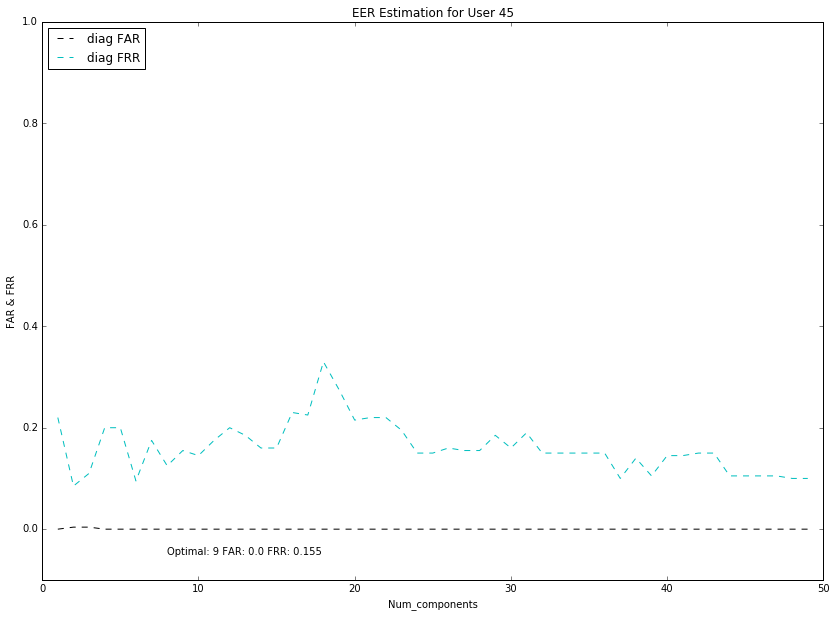

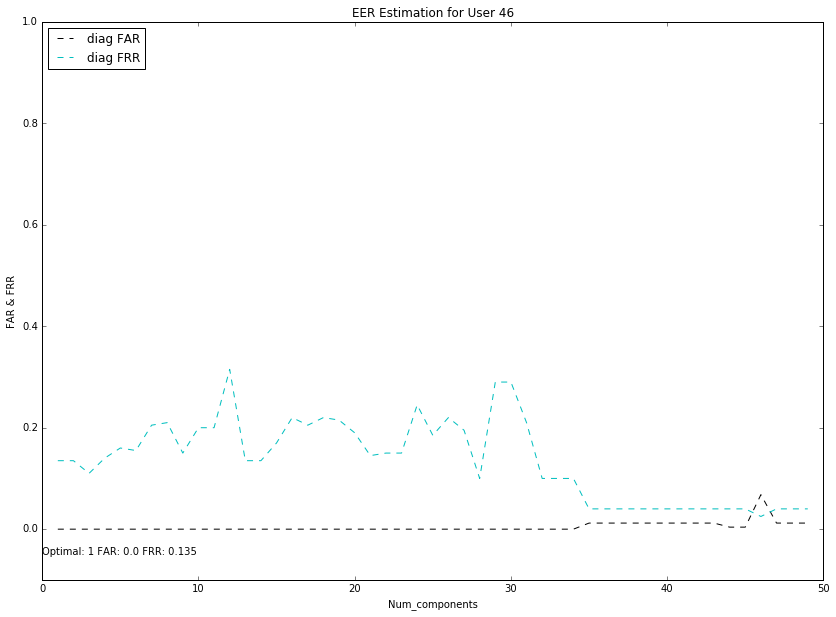

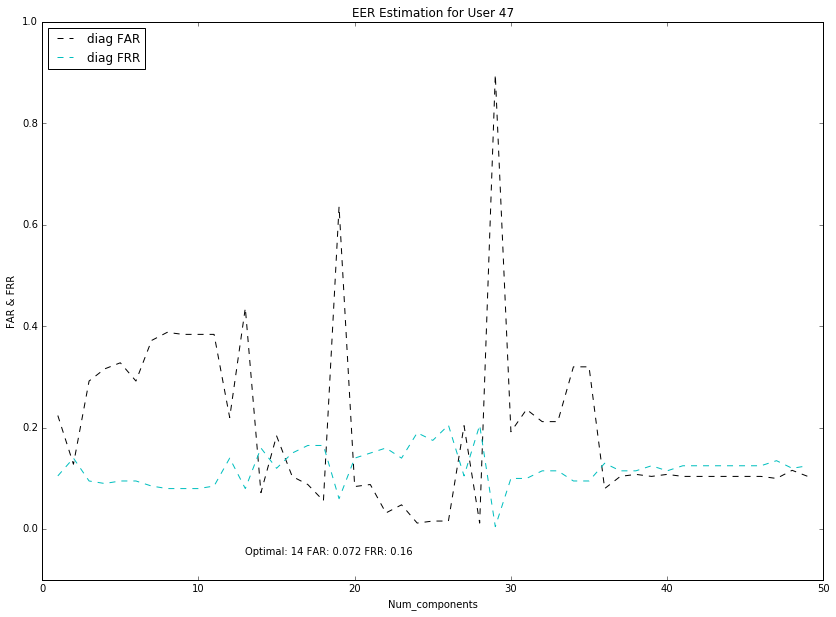

In [11]:
import random;
from time import clock;

user_range = range(45,48) ##  range of user. Totally 51 users
n_components_range = range(1, 50); ## num_components: 1~50
K_range = np.arange(0.01, 2.01, 0.02); ## 0.01~1.99, variance is 0.02
# covariances=['spherical', 'diag', 'full', 'tied'];

## For debug
color_line = [['k', 'c']];
color_list = ['k'];
covariances = ['diag']; 

Opt_n_components = dict((covar_type, []) for covar_type in covariances);
Opt_EER = dict((covar_type, []) for covar_type in covariances);
Opt_K = dict((covar_type, []) for covar_type in covariances);
K = 0.5;

#### User Loop
for index_user in user_range: ## Try the first 10 user
    print 'Processing on User: ', index_user;
    
    plt.figure(figsize=(14,10)); ## One picture per user
    plt.title("EER Estimation for User " + str(index_user));

    trainTarget, trainSet, testTarget, testSet = pre_process(data_user[index_user], 2, True);
    ## Choose 50 users randomly as the training set
    trainIndex = [random.randrange(0, len(trainSet), 3) for i in range(50)];
    trainSet = np.array([trainSet[i] for i in trainIndex]);
    print "Size of trainSet: ", len(trainSet);
    
    imposterSet = np.concatenate((imposter_features[0:index_user], 
                                  imposter_features[index_user+1:])).reshape(imposter_size-imposter_size_per_user, 28);
    print "Size of imposterSet: ", len(imposterSet);
    genuine_user = np.array(testSet);
    imposter_user = imposterSet;
    loo = cross_validation.LeaveOneOut(len(trainSet)); ## LOOM method iterator
    
    # Grid search on K, covar_type, n_components (Implemented by myself)
    #### Covar_type Loop
    for index_covar, (covar_type, color) in enumerate(zip(covariances, color_list)):
        print color[index_covar];
        print "Covar_type: ", covar_type;
        EER = np.array([]);
        FAR, FRR, Dis =[], [], [];
        opt_pos, min_err = 0, np.infty;
        start = clock();
        
        #### n_components Loop
        for num_components in n_components_range:
            model = GMM(n_components=num_components, covariance_type=covar_type, init_params='wc', n_iter=20);
            min_dis = np.infty; ## distance between FAR & FRR
            eer_k, eer_far, eer_frr = 0, 0, 0; ## the value of LOOM K, FAR and FRR at EER point
            
            ## LOOM Method
            Scores = [];
            for train_index, test_index in loo:
                train, test = trainSet[train_index], trainSet[test_index];
                model.fit(train);
                Scores.append(model.score(test));

            model.fit(trainSet);
            Scores = np.array(Scores).ravel();
            mean = np.mean(Scores);
            std = np.std(Scores);
            # print "mean: ", mean, " std: ", std;

            scores_imposter = [model.score(imposter_user[i].reshape(1,-1)) for i in range(len(imposter_user))];
            scores_genuine = [model.score(genuine_user[i].reshape(1,-1)) for i in range(len(genuine_user))];
            
            #Evalutation of the model
            ## K Loop
            Seq = [Scores[j] for j in range(len(Scores)) if abs(Scores[j] - mean) < K*std];
            if(not Seq):
                threshold_user = mean - K*std;
            else:
                threshold_user = min(Seq);

            reject, accept = 0, 0;
            ## imposter test
            for i in range(len(scores_imposter)):
                if(scores_imposter[i] >= threshold_user):
                     accept = accept+1;

            ## genuine test    
            for i in range(len(scores_genuine)):
                if(scores_genuine[i] < threshold_user):
                    reject = reject+1;
                        
            far = (float(accept)/float(len(scores_imposter)));
            frr = (float(reject)/float(len(scores_genuine)));
            
            FAR.append(far); FRR.append(frr); Dis.append(abs(far-frr));
            
        
        #### End of n_components Loop
        finish = clock();
        print "Time interval: ", finish-start;
        
        ## Find the optimal point: Find the 5 smallest FAR points,
        ## and choose the one who has the lowest FRR as the optimal
        index_close = np.argsort(FAR)[:5];
        opt_pos = FRR.index(min(np.array(FRR)[index_close]))
        
        Opt_n_components[covar_type].append(opt_pos+1); ## The n_components of the model under this cover_type with minimal EER
        
        plt.plot(n_components_range, FAR, '--', color=color_line[index_covar][0], label=covar_type+" FAR");
        plt.plot(n_components_range, FRR, '--', color=color_line[index_covar][1], label=covar_type+" FRR");
        plt.text(opt_pos, -0.05, 'Optimal: '+str(opt_pos+1)
                 +' FAR: '+str(FAR[opt_pos])+' FRR: '+str(FRR[opt_pos]), color = color);

    #### End of covar_type Loop
    
    plt.xlabel("Num_components");
    plt.ylabel("FAR & FRR");
    plt.ylim(ymin=-0.1, ymax = 1.0);
    plt.legend(loc='upper left');

#### End of User Loop
    
## Show the optimal EER of different Users
# plt.figure(figsize=(10, 10));
# bars_eer = [];
# for index, (covar_type, color) in enumerate(zip(covariances, color_list)):
#     xpos = np.array(user_range)+.2*index;
#     bars_eer.append((plt.bar(xpos, Opt_EER[covar_type], width=.2, color=color)));
#     plt.plot(np.array(user_range)+.2*index, Opt_EER[covar_type], '--', color=color, label=covar_type);
    
#     for i in range(len(xpos)):
#         plt.text(xpos[i], Opt_EER[covar_type][i]*1.01, 'Num_components: '+str(Opt_n_components[covar_type][i])
#                  +' K: '+str(Opt_K[covar_type][i]), fontsize=14);
        

# plt.title("FAR&FRR with different num_components with the same K_LOOM of Different Users");
# plt.xlabel("User Index");
# plt.ylabel("FAR & FRR");
# plt.legend(loc='upper right');

## Demonstration of Verification System
* Use HTML and Javascript build a front end page to simulate the login page of authentication system. Record what the user types in and extract keystroke features. (Front-End: HTML + Javascript)

* Back-end receive the keystroke information and pre-process it (Filter the mistake and extract the features in proper format). Use the model built with GMM+LOOM to verify the user. (Python)

* Back-end passes the verification result to front-end. Front-end visualizes the result whether user's authentication is successful.

### Verify user's identity with feature vector and GMM+LOOM
* This is the core part of our demostration. We will use the model built by GMM+LOOM to verify user's identity. Feature vector is generated by the information extracted in the front-end. 
* Let model training be functional. This part should include setting parameter automative.
* The two following functions are for verification. "train_Model_GMM_LOOM" trains the GMM model and gets the LOOM threshold. It return a model and a threshold as a profile for a user.
* "make_Authentication" uses specific user's model and threshold to verify whether the input feature is below to this user. Means doing the authentication.

In [9]:
def searchOfParameters(train_data, index_user): ## For now, size of train_data should be at least 50
    
    kf = cross_validation.KFold(len(train_data), n_folds=5, shuffle=True);
    train_index, test_index = next(iter(kf));
    train, test = train_data[train_index], train_data[test_index];
    if(len(train) < 40):
        trainSet = np.array(train_data);
        genuine_user = trainSet;
    else:
        trainSet = train;
        if(len(test) >= 100):
            genuine_user = test;
        else:
            genuine_user = train_data;
    
    n_components_range = range(1, len(train)-10); ## num_components: 1~50
    K_range = np.arange(0.01, 2.01, 0.01); ## 0.01~1.99, variance is 0.01
#     covariances = ['spherical', 'diag', 'full', 'tied'];
    covariances = ['diag']; ## seems like the best covar_type is 'diag' surely
    
    Opt_n_components = dict((covar_type, 0) for covar_type in covariances);
    Opt_EER = dict((covar_type, 0) for covar_type in covariances);
    Opt_K = dict((covar_type, 0) for covar_type in covariances);
    
    ## extract imposter from the imposter pool
    imposter_user = np.concatenate((imposter_features[0:index_user], 
                                    imposter_features[index_user+1:])).reshape(imposter_size-imposter_size_per_user, 28);
    genuine_user = np.array(genuine_user);
    
    loo = cross_validation.LeaveOneOut(len(trainSet));
    
    for covar_type in covariances:
        EER, K_Seq, FAR, FRR = [], [], [], [];
        
        for num_components in n_components_range:
            model = GMM(n_components=num_components, covariance_type=covar_type, init_params='wc', n_iter=20);
            min_dis = np.infty; ## distance between FAR & FRR
            eer_k, eer_far, eer_frr = 0, 0, 0; ## the value of LOOM K, FAR and FRR at EER point
            
            Scores = [];
            for train_index, test_index in loo:
                train, test = trainSet[train_index], trainSet[test_index];
                model.fit(train);
                Scores.append(model.score(test));
                
            model.fit(trainSet);
            Scores = np.array(Scores).ravel();
            mean = np.mean(Scores);
            std = np.std(Scores);
            
            scores_imposter = [model.score(imposter_user[i].reshape(1,-1)) for i in range(len(imposter_user))];
            scores_genuine = [model.score(genuine_user[i].reshape(1,-1)) for i in range(len(genuine_user))];
            
            for K in K_range:
                Seq = [Scores[j] for j in range(len(Scores)) if abs(Scores[j] - mean) < K*std];
                if(not Seq):
                    threshold_user = mean - K*std;
                else:
                    threshold_user = min(Seq);
                    
                reject, accept = 0, 0;
                ## imposter test
                for i in range(len(scores_imposter)):
                    if(scores_imposter[i] >= threshold_user):
                        accept = accept+1;

                ## genuine test
                for i in range(len(scores_genuine)):
                    if(scores_genuine[i] < threshold_user):
                        reject = reject+1;
                        
                far = (float(accept)/float(len(scores_imposter)));
                frr = (float(reject)/float(len(scores_genuine)));
                
                ## Find the optimal point and record it 
                if(min_dis > abs(far-frr)):
                    min_dis = abs(far-frr);
                    ## eer = (far, frr);
                    eer = np.mean([far, frr]); ## I am not sure whether it's approprate
                    eer_k, eer_far, eer_frr = K, far, frr;
                    
            ### End of K Loop
            K_Seq.append(eer_k);
            EER.append(eer);
            FAR.append(eer_far);
            FRR.append(eer_frr);
            
        ###End of n_components Loop
        min_eer = min(EER);
        opt_pos = EER.index(min_eer); ## n_components begins from 1
        Opt_K[covar_type] = K_Seq[opt_pos]; ## The K value of the minimal EER model
        Opt_n_components[covar_type] = opt_pos+1; ## The n_components of the model under this cover_type with minimal EER
        Opt_EER[covar_type] = min_eer; ## The minimal EER under this cover_type in the n_components range(1,50)
    
    ### End of covar_type Loop
    covar_type = min(Opt_EER); ## choose the minimal EER as the optimal situation
    K = Opt_K[covar_type];
    n_components = Opt_n_components[covar_type];
    parameters = {'n_components': n_components, 'covar_type': covar_type, 'K': K};
    return parameters;

In [10]:
def train_Model_GMM_LOOM(train_data, index_user, n_components=None, covar_type='diag', k_loom=None, auto=True):
    ## TODO
    ## Set the paramter of GMM model (How to find the optimal value automatively)
    if (auto):
        parameters = searchOfParameters(train_data, index_user);
        model = GMM(n_components=parameters['n_components'], covariance_type=parameters['covar_type'], 
                    init_params='wc', n_iter=20);
        k_loom = parameters['K'];
        
    else:
        model = GMM(n_components=n_components, covariance_type=covar_type, 
                   init_params='wc', n_iter=20);
    
    ##LOOM Method
    loo = cross_validation.LeaveOneOut(len(train_data));
    print(len(train_data));
    Scores = [];
    for train_index, test_index in loo:
        train, test = train_data[train_index], train_data[test_index];
        model.fit(train);
        Scores.append(model.score(test));
    
    Scores = np.array(Scores).ravel();
    mean = np.mean(Scores); std = np.std(Scores);    
        
    Seq = [Scores[i] for i in range(len(Scores)) if abs(Scores[i] - mean) < k_loom*std];
    if(not Seq):
        threshold = mean - k_loom*std;
    else:
        threshold = min(Seq);
    
    ##Train the GMM model
    model.fit(train_data);
    profile = dict({'model': model, 'threshold': threshold});
    return profile;

def make_Authentication(model, threshold, feature):
    
    score = model.score(feature);
    
    ## This kind of return contains more information. It is only for demo and testing phase
    if(score < threshold):
        return [False, score[0], threshold];
    else:
        return [True, score[0], threshold];

### Demo Initialization

* Initialize the basic setting of the demo. Including: data structure for the key event (KeyEvent); profiles for initial users (Profiles); the lists which saves keyevent information.

In [11]:
from IPython.display import HTML

## Use this class to record the keystroke information from the front-end (Javascript)
class KeyEvent:
    keyCount = 0;
    
    def __init__(self, index, key, which, time_D, time_U):
        self.index = index; ## The index of pressing sequence
        self.key = key; 
        self.which = which; ## Keycode
        self.time_D = time_D;
        self.time_U = time_U;
        KeyEvent.keyCount += 1;

## save the keystroke information
Username_index, Username_key, Username_which, Username_time_D, Username_time_U = [], [], [], [], [];
Password_index, Password_key, Password_which, Password_time_D, Password_time_U = [], [], [], [], [];

## organize keystroke information into a dictionary.
Username_keyMap, Password_keyMap = {}, {};

username, password = str(), str(); ## username and password which user uses in the front-end
Profiles = dict({}); ## Store users' profiles in Demo

for index in range(45, 50):
    train_target, train_feature, test_target, test_feature = pre_process(data_user[index], 2, True); ## Size of trainSet: 200
    
    # Choose 50 users randomly as the training set
    trainIndex = [random.randrange(0, len(train_feature), 3) for i in range(50)];
    train_feature = np.array([train_feature[j] for j in trainIndex]);
    
    print type(train_feature), train_feature.shape;
#     Profiles['User'+str(index)] = {"Password": ".tie5roanl",
#                                "Keystroke": train_Model_GMM_LOOM(train_feature, index_user=index)};
    Profiles['User'+str(index)] = {"Password": ".tie5roanl",
                               "Keystroke": train_Model_GMM_LOOM(train_feature, index_user=index, 
                                                                 n_components=1, k_loom=0.25, auto=False)};
print Profiles;

sklearn.cross_validation.KFold(n=400, n_folds=2, shuffle=True, random_state=None)
<type 'numpy.ndarray'> (50L, 28L)
50
sklearn.cross_validation.KFold(n=400, n_folds=2, shuffle=True, random_state=None)
<type 'numpy.ndarray'> (50L, 28L)
50
sklearn.cross_validation.KFold(n=400, n_folds=2, shuffle=True, random_state=None)
<type 'numpy.ndarray'> (50L, 28L)
50
sklearn.cross_validation.KFold(n=400, n_folds=2, shuffle=True, random_state=None)
<type 'numpy.ndarray'> (50L, 28L)
50
sklearn.cross_validation.KFold(n=400, n_folds=2, shuffle=True, random_state=None)
<type 'numpy.ndarray'> (50L, 28L)
50
{'User49': {'Password': '.tie5roanl', 'Keystroke': {'threshold': -37.654078723664455, 'model': GMM(covariance_type='diag', init_params='wc', min_covar=0.001, n_components=1,
  n_init=1, n_iter=20, params='wmc', random_state=None, thresh=None,
  tol=0.001, verbose=0)}}, 'User48': {'Password': '.tie5roanl', 'Keystroke': {'threshold': -16.303721710504334, 'model': GMM(covariance_type='diag', init_params='

In [12]:
py_profile_auto = {"Password": ".tie5roanl", "Keystroke": train_Model_GMM_LOOM(py_data[0:50], index_user=1, auto=True)};
py_profile_man = {"Password": ".tie5roanl", "Keystroke": 
              train_Model_GMM_LOOM(py_data[0:50], index_user=1, n_components=32, covar_type='diag', k_loom=0.01, auto=False)};

print py_profile_auto;
print py_profile_man;

false_cmu, false_py_auto, false_py_man = 0, 0, 0;
imposter_user = np.array(imposter_features[0:50]).reshape(imposter_size-imposter_size_per_user, 28);
imposter_user = np.array(data_user[46][:][:, 3:]);
for i in range(len(imposter_user)):
    result_CMU = make_Authentication(Profiles['User47']['Keystroke']['model'], 
                                 Profiles['User47']['Keystroke']['threshold'], 
                                 imposter_user[i].reshape(1,-1));
    
    result_py_auto = make_Authentication(py_profile_auto['Keystroke']['model'], 
                                 py_profile_auto['Keystroke']['threshold'], 
                                 imposter_user[i].reshape(1,-1));
    
    result_py_man = make_Authentication(py_profile_man['Keystroke']['model'], 
                                 py_profile_man['Keystroke']['threshold'], 
                                 imposter_user[i].reshape(1,-1));
    
    if(result_CMU[0] == True):
        false_cmu += 1;
        
    if(result_py_auto[0] == True):
        false_py_auto += 1;
        
    if(result_py_man[0] == True):
        false_py_man += 1;

print "CMU test: ", float(false_cmu)/float(len(imposter_user));
print "Personal test auto: ", float(false_py_auto)/float(len(imposter_user));
print "Personal test manual: ", float(false_py_man)/float(len(imposter_user));
Profiles['User1'] = py_profile_auto;
print Profiles;

50
50
{'Password': '.tie5roanl', 'Keystroke': {'threshold': -68.800736715454676, 'model': GMM(covariance_type='diag', init_params='wc', min_covar=0.001,
  n_components=28, n_init=1, n_iter=20, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)}}
{'Password': '.tie5roanl', 'Keystroke': {'threshold': -84.489496465698096, 'model': GMM(covariance_type='diag', init_params='wc', min_covar=0.001,
  n_components=32, n_init=1, n_iter=20, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)}}
CMU test:  0.13
Personal test auto:  0.0
Personal test manual:  0.0
{'User47': {'Password': '.tie5roanl', 'Keystroke': {'threshold': -27.553157579895107, 'model': GMM(covariance_type='diag', init_params='wc', min_covar=0.001, n_components=1,
  n_init=1, n_iter=20, params='wmc', random_state=None, thresh=None,
  tol=0.001, verbose=0)}}, 'User46': {'Password': '.tie5roanl', 'Keystroke': {'threshold': -27.330554531518203, 'model': GMM(covariance_type='diag', init_params='wc'

### Front-End (HTML+Javascript)
   The front-end of this demo is written by html and javascript. For the convinence, I integrate the front-end code in notebook. With integrating back-end and front-end in one notebook, we can easily tune the algorithm and find the implicit problems in our system

In [13]:
%%html
<head>
    <meta http-equiv="Content-Type" content="text/html; charset=ISO-8859-1"/>
    <title>Keystroke demo</title>
    <script type="text/javascript" src="WebContent/js/UI.js"></script>
    <script type="text/javascript" src="WebContent/js/keystroke.js"></script>
    <link rel="stylesheet" type="text/css" href="WebContent/css/style_notebook.css"/>
</head>

<body id="body_inside">
    <h1 id="h1">Keystroke Demo</h1>
    <div class="target">
        <fieldset class="input">
            <label for="username" >Username:</label>
            <input id="username" type="text">
        </fieldset>
    
        <fieldset class="input">
            <label for="password">Password:</label>
            <input id="password" type="text">
        </fieldset>
    
        <button id="sign up" onclick="collect_code()">Sign up</button>
        <button id="login" onclick="exec_code()">Login</button>
    </div>
    
    <h2 id="h2">The Record Information</h2>
    
    <div class="print-output">
        <fieldset class="output">
            <label for="username-typed">Username-typed:</label>            
            <input id="username-typed" type="text" size="50"><br>
            <label for="password-typed">Password-typed:</label>            
            <input id="password-typed" type="text" size="50"><br>
            <label for="result-backend">Result-backend:</label>            
            <input id="result-backend" type="text" size="50"><br>
        </fieldset>
    </div>
    
    <script type="text/Javascript">
        var kernel = IPython.notebook.kernel;
        
        function handle_output(out) {
            console.log(out);
            var res = null, text = null;
            
             // if output is a print statement
            if(out.msg_type == "stream") {
                console.log("stream");
                res = out.content.text;
                console.log(res);
            }
            
            // if output is a python object
            else if(out.msg_type === "execute_result") {
                console.log("execute_result");
                res = out.content.data["text/plain"];
                if(res.length > 1) {
                    var content = res.replace(/\[|\]/g, ''); //'g' means global match
                    console.log(content);
                    content = content.split(',');
                    res = content[0];
                    var score = content[1], threshold = content[2];
                }
                console.log(typeof res);
                console.log(res);
                switch(res) {
                    case "True": //authentication successful
                        text = "Congratulation! Authentication succeeded"
                        res = "score: " + score + '; threshold: ' + threshold;
                        break;
                    
                    case "False": //keystroke authentication failed
                        text = "Oh... Keystroke Authentication failed! Who r u +_+";
                        res = "score: " + score + '; threshold: ' + threshold;
                        break;
                    
                    case '2': //Can not find the user
                        console.log(res);
                        text = "Can't find this user";
                        break;
                    
                    case '3': //Password is wrong
                        console.log(res);
                        text = "Password is not correct";
                        break;
                    default:
                        text = "The result from the back-end is not recognized"
                        break;
                }
                alert(text);
            }
            
            // if output is a python error
            else if(out.msg_type === "pyerr") {
                console.log("pyeer");
                res = out.content.ename + ": " + out.content.evalue;
            }
            // if output is something we haven't thought of
            else {
                res = "[out type not implemented]";   
            }
            document.getElementById("result-backend").value = res;
        }
        
        function exec_code() {
            document.getElementById("username-typed").value = Username_text;
            document.getElementById("password-typed").value = Password_text;
            
            // extract username and password
            kernel.execute("username = '" + document.getElementById("username").value + "'");
            kernel.execute("password = '" + document.getElementById("password").value + "'");
            
            // extract keystroke feature
            kernel.execute("Username_index, Username_key, Username_which, Username_time_D, Username_time_U = [], [], [], [], [];");
            kernel.execute("Password_index, Password_key, Password_which, Password_time_D, Password_time_U = [], [], [], [], [];");
            
            for(i = 0; i < Feature_Username.length; i++) {
                var command_index = "Username_index.append(" + Feature_Username[i].index + ")";
                var command_key = "Username_key.append('" + Feature_Username[i].key + "')";
                var command_which = "Username_which.append(" + Feature_Username[i].which + ")";
                var command_time_D = "Username_time_D.append(" + Feature_Username[i].time_D + ")";
                var command_time_U = "Username_time_U.append(" + Feature_Username[i].time_U + ")";
                
                console.log("Executing Command: " + command_index + command_key + command_which
                            + command_time_D + command_time_U);
                kernel.execute(command_index);
                kernel.execute(command_key);
                kernel.execute(command_which);
                kernel.execute(command_time_D);
                kernel.execute(command_time_U);
            }
            kernel.execute("Username_keyMap = {'index': Username_index, 'key': Username_key, 'which': Username_which, 'time_D': Username_time_D, 'time_U': Username_time_U}");
            
            for(i = 0; i < Feature_Password.length; i++) {
                var command_index = "Password_index.append(" + Feature_Password[i].index + ")";
                var command_key = "Password_key.append('" + Feature_Password[i].key + "')";
                var command_which = "Password_which.append(" + Feature_Password[i].which + ")";
                var command_time_D = "Password_time_D.append(" + Feature_Password[i].time_D + ")";
                var command_time_U = "Password_time_U.append(" + Feature_Password[i].time_U + ")";
                
                console.log("Executing Command: " + command_index + command_key + command_which
                            + command_time_D + command_time_U);
                kernel.execute(command_index);
                kernel.execute(command_key);
                kernel.execute(command_which);
                kernel.execute(command_time_D);
                kernel.execute(command_time_U);
                
            }
            kernel.execute("Password_keyMap = {'index': Password_index, 'key': Password_key, 'which': Password_which, 'time_D': Password_time_D, 'time_U': Password_time_U}"); 
            
            //Deal with the authenticat ion result returned from python back-end
            var callbacks = {'iopub': {'output' : handle_output}};
            kernel.execute("authentication_Main()", callbacks, {silent:false});
            console.log("login pressed");
        }
        
        
        function collect_code() {
            document.getElementById("username-typed").value = Username_text;
            document.getElementById("password-typed").value = Password_text;
            
            // extract username and password
            kernel.execute("username = '" + document.getElementById("username").value + "'");
            kernel.execute("password = '" + document.getElementById("password").value + "'");
            
            // extract keystroke feature
            kernel.execute("Username_index, Username_key, Username_which, Username_time_D, Username_time_U = [], [], [], [], [];");
            kernel.execute("Password_index, Password_key, Password_which, Password_time_D, Password_time_U = [], [], [], [], [];");
            
            for(i = 0; i < Feature_Username.length; i++) {
                var command_index = "Username_index.append(" + Feature_Username[i].index + ")";
                var command_key = "Username_key.append('" + Feature_Username[i].key + "')";
                var command_which = "Username_which.append(" + Feature_Username[i].which + ")";
                var command_time_D = "Username_time_D.append(" + Feature_Username[i].time_D + ")";
                var command_time_U = "Username_time_U.append(" + Feature_Username[i].time_U + ")";
                
                kernel.execute(command_index);
                kernel.execute(command_key);
                kernel.execute(command_which);
                kernel.execute(command_time_D);
                kernel.execute(command_time_U);
            }
            kernel.execute("Username_keyMap = {'index': Username_index, 'key': Username_key, 'which': Username_which, 'time_D': Username_time_D, 'time_U': Username_time_U}");
            
            for(i = 0; i < Feature_Password.length; i++) {
                var command_index = "Password_index.append(" + Feature_Password[i].index + ")";
                var command_key = "Password_key.append('" + Feature_Password[i].key + "')";
                var command_which = "Password_which.append(" + Feature_Password[i].which + ")";
                var command_time_D = "Password_time_D.append(" + Feature_Password[i].time_D + ")";
                var command_time_U = "Password_time_U.append(" + Feature_Password[i].time_U + ")";
                
                kernel.execute(command_index);
                kernel.execute(command_key);
                kernel.execute(command_which);
                kernel.execute(command_time_D);
                kernel.execute(command_time_U);
                
            }
            kernel.execute("Password_keyMap = {'index': Password_index, 'key': Password_key, 'which': Password_which, 'time_D': Password_time_D, 'time_U': Password_time_U}"); 
            
            //Deal with the authenticat ion result returned from python back-end
            var callbacks = {'iopub': {'output' : handle_output}};
            kernel.execute("collect_NewUser()", callbacks, {silent:false});
            console.log("'sign up' pressed");
            
            Released_Key.splice(0, Released_Key.length);
            Username_text.splice(0, Username_text.length);
            Password_text.splice(0, Password_text.length);
        }
        
    </script>
    
</body>

#### Collect new user's information to generate new profiles

In [44]:
def collect_NewUser():

    Username = "PuYang";
    Password = ".tie5roanl";
    
    if(Username != username):
        print "This user doesn't exist";
        return 2;
    elif(Password != password):
        print "Password is not correct";
        return 3;
    
    print Username_keyMap, Password_keyMap;
    
    Username_keyevent = [KeyEvent(Username_keyMap['index'][i], Username_keyMap['key'][i], 
                                  Username_keyMap['which'][i], Username_keyMap['time_D'][i], 
                                  Username_keyMap['time_U'][i]) for i in range(len(Username_keyMap['index']))];

    Password_keyevent = [KeyEvent(Password_keyMap['index'][i], Password_keyMap['key'][i], 
                                  Password_keyMap['which'][i], Password_keyMap['time_D'][i], 
                                  Password_keyMap['time_U'][i]) for i in range(len(Password_keyMap['index']))];    
    
    ## Deal with typing mistake and generate feature vector
    ## sort by pressed index. The orginal vector is in sequence of release
    Press_Sequence_Username = sorted(Username_keyevent, key=lambda keyevent: keyevent.index);
    Press_Sequence_Password = sorted(Password_keyevent, key=lambda keyevent: keyevent.index);
    
    RemoveMistake(Press_Sequence_Username);
    RemoveMistake(Press_Sequence_Password);
    
    ## Look for user's correct password as reference according to its username
    ## The real password is used as the reference which helps us to extract the keystroke feature
    Username_Keystroke = extract_Feature(Press_Sequence_Username, Username);
    Password_Keystroke = extract_Feature(Press_Sequence_Password, Password);

    ## Generate feature vectors for each sub-feature, 
    ## four kinds of sub-features: hold-time, DDKL, UDKL, UUKL
    H_time_Username = [(Username_Keystroke[i].time_U - Username_Keystroke[i].time_D)/1000
                       for i in range(len(Username_Keystroke))];
    H_time_Password = [(Password_Keystroke[i].time_U - Password_Keystroke[i].time_D)/1000 
                       for i in range(len(Password_Keystroke))];

    DDKL_Username = [(Username_Keystroke[i+1].time_D - Username_Keystroke[i].time_D)/1000 
                     for i in range(len(Username_Keystroke)-1)];
    DDKL_Password = [(Password_Keystroke[i+1].time_D - Password_Keystroke[i].time_D)/1000
                     for i in range(len(Password_Keystroke)-1)];

    UDKL_Username = [(Username_Keystroke[i+1].time_D - Username_Keystroke[i].time_U)/1000 
                     for i in range(len(Username_Keystroke)-1)];
    UDKL_Password = [(Password_Keystroke[i+1].time_D - Password_Keystroke[i].time_U)/1000 
                     for i in range(len(Password_Keystroke)-1)];

    UUKL_Username = [(Username_Keystroke[i+1].time_U - Username_Keystroke[i].time_U)/1000
                     for i in range(len(Username_Keystroke)-1)];
    UUKL_Password = [(Password_Keystroke[i+1].time_U - Password_Keystroke[i].time_U)/1000 
                     for i in range(len(Password_Keystroke)-1)];
    
    ## Feature_Vector is the final feature vector which is used to verify user's keystroke
    ## Generate feature's vector used for authentication
    Feature_Vector = [];
    for i in range(len(H_time_Password)):
        Feature_Vector.append(round(H_time_Password[i], 4));
        if(i < len(DDKL_Password)):
            Feature_Vector.append(round(DDKL_Password[i], 4));
            Feature_Vector.append(round(UDKL_Password[i], 4));
            
    ## Write features to a new csv file
    with open('Dataset/New Users/PUYang.csv', 'a') as csvfile:
        spamwriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting = csv.QUOTE_MINIMAL);
        spamwriter.writerow(Feature_Vector);
        print "Write to CSV file";

### Extract and generate feature vector from the what user types in the front-end
   * Extract four kinds of keystroke feature: hold-time, DDKL, UDKL, UUKL. Feature vector stands for user's typing habit behavior. 
   
   
   * One important point is that, the sequence of key-press and key-release could be a chaos. So we should generate thefeature vector with a predefine format. This format depends on user's true username and password
   
   
   * The function "RemoveMistake" is used for the user's typing mistake. Typing mistake means the mistake that users make while typing their username and password. Generally, if users make some typing mistakes, they will delete mistakes and type in again.
   
   
   * So we should filter the typing mistakes and extract the effective typed charactors. (Attentation!! "Enter" is printable)
   
   
   * The function below: "extract_Feature", is able to remove the redundency in the data. Get keys which contain the keystroke feature's information

In [14]:
import string

def isPrintable(text):
    printset = set(string.printable);
    return set(text).issubset(printset);

def RemoveMistake(Content):
    ## Deal with typing mistake and generate feature vector
    ## Backspace: 
    length = len(Content);
    i = 0;
    while(i < length):
        item = Content[i];
        if(item.which == 8):
            ## remove Backspace and other keys that user deletes because of mistake
            ## if find a Backspace, delete the Backspace and the key in front of it
            ## additional Backspace: only remove Backspace
            if(i == 0):
                del Content[i];
                length -= 1;
                i -= 1;
            ## remove the Backspace and wrong characters
            else:
                ## remove all the other non-printable char before the Backspace
                while(not isPrintable(Content[i-1].key)):
                    del Content[i-1];
                    i -= 1; length -= 1;
                    
                ## remove the printable char that should be remove by this Backspace    
                del Content[i-1:i+1];
                length -= 2;
                i -= 2;
        i += 1;
        
## After removing the typing mistakes, the text still may have lots of redundancy. 
## Like continuous 'Shift (which:16)', non-printable charactors at the begining and the end.
## This function help us to remove those redundancy and extract the correct charcators containing the feature information

def extract_Feature(Press_Sequence, Reference):## Reference means the correct username or password
    Feature = [];
    i = len(Press_Sequence)-1;
    j = len(Reference)-1;
#     i,j = 0,0;
    ## match the sequence from the backward
#     while(i < len(Press_Sequence) and j < len(Reference)):
    while(i >= 0 and j >= 0):
        if(Press_Sequence[i].key == Reference[j]):
            ## if the char is in upper case, and the previous pressed key is 'shift'
            ## if so, take the 'shift' into the feature vector
#             print Press_Sequence[i].key;
            if(Press_Sequence[i].key.isupper() and Press_Sequence[i-1].which == 16):
                print Press_Sequence[i].key;
                Feature.append(Press_Sequence[i-1]);

            Feature.append(Press_Sequence[i]);
#             j += 1;
            j -= 1;
        i -= 1;
#         i += 1;
    
    Feature.reverse();
    return Feature;

### Main function of back-end
* The whole procedure and all the functions of authentication demo are integrated in this main function. When user tries to login from the front-end, the front-end will triger this main function to operate authentication.


* Function "authentication_Main" is the main function of the back-end. It will use the information from the front-end to make the final decision and send it back to front-end. At last, front-end will visualize the final result to users.

In [15]:
def authentication_Main():
    ## TODO: in real case, this part should search in database
    ## In demo, this part only search in the dictionary "Profiles" which contains users' information 
    
    if(not Profiles.has_key(username)):
        print "This user doesn't exist";
        return 2;
    elif(Profiles[username]["Password"] != password):
        print "Password is not correct";
        return 3;

    Username = username;
    Password = password;
    ## Password.append("Enter"); ## Because we should let the password be compatible with CMU password
    
    Username_keyevent = [KeyEvent(Username_keyMap['index'][i], Username_keyMap['key'][i], 
                                  Username_keyMap['which'][i], Username_keyMap['time_D'][i], 
                                  Username_keyMap['time_U'][i]) for i in range(len(Username_keyMap['index']))];

    Password_keyevent = [KeyEvent(Password_keyMap['index'][i], Password_keyMap['key'][i], 
                                  Password_keyMap['which'][i], Password_keyMap['time_D'][i], 
                                  Password_keyMap['time_U'][i]) for i in range(len(Password_keyMap['index']))];    
    
    ## Deal with typing mistake and generate feature vector
    ## sort by pressed index. The orginal vector is in sequence of release
    Press_Sequence_Username = sorted(Username_keyevent, key=lambda keyevent: keyevent.index);
    Press_Sequence_Password = sorted(Password_keyevent, key=lambda keyevent: keyevent.index);
    
    RemoveMistake(Press_Sequence_Username);
    RemoveMistake(Press_Sequence_Password);
    
    ## Look for user's correct password as reference according to its username
    ## The real password is used as the reference which helps us to extract the keystroke feature
    Username_Keystroke = extract_Feature(Press_Sequence_Username, Username);
    Password_Keystroke = extract_Feature(Press_Sequence_Password, Password);

    ## Generate feature vectors for each sub-feature, 
    ## four kinds of sub-features: hold-time, DDKL, UDKL, UUKL
    H_time_Username = [(Username_Keystroke[i].time_U - Username_Keystroke[i].time_D)/1000
                       for i in range(len(Username_Keystroke))];
    H_time_Password = [(Password_Keystroke[i].time_U - Password_Keystroke[i].time_D)/1000 
                       for i in range(len(Password_Keystroke))];

    DDKL_Username = [(Username_Keystroke[i+1].time_D - Username_Keystroke[i].time_D)/1000 
                     for i in range(len(Username_Keystroke)-1)];
    DDKL_Password = [(Password_Keystroke[i+1].time_D - Password_Keystroke[i].time_D)/1000
                     for i in range(len(Password_Keystroke)-1)];

    UDKL_Username = [(Username_Keystroke[i+1].time_D - Username_Keystroke[i].time_U)/1000 
                     for i in range(len(Username_Keystroke)-1)];
    UDKL_Password = [(Password_Keystroke[i+1].time_D - Password_Keystroke[i].time_U)/1000 
                     for i in range(len(Password_Keystroke)-1)];

    UUKL_Username = [(Username_Keystroke[i+1].time_U - Username_Keystroke[i].time_U)/1000
                     for i in range(len(Username_Keystroke)-1)];
    UUKL_Password = [(Password_Keystroke[i+1].time_U - Password_Keystroke[i].time_U)/1000 
                     for i in range(len(Password_Keystroke)-1)];
    
    ## Feature_Vector is the final feature vector which is used to verify user's keystroke
    ## Generate feature's vector used for authentication
    Feature_Vector = [];
    for i in range(len(H_time_Password)):
        Feature_Vector.append(H_time_Password[i]);
        if(i < len(DDKL_Password)):
            Feature_Vector.append(DDKL_Password[i]);
            Feature_Vector.append(UDKL_Password[i]);
    
    ## Feature normalization
    for i in range(len(Feature_Vector)):
        Feature_Vector[i] = (Feature_Vector[i]-global_Mean[i])/global_Std[i];

    ## For demo and testing phase
    result = make_Authentication(Profiles[Username]['Keystroke']['model'], 
                           Profiles[Username]['Keystroke']['threshold'],
                           np.array(Feature_Vector).reshape(1,-1));
    return result;

### Test 
* The following parts are for testing the functions.


* Pre-process the typing data collected from the front-end. Including removing typing mistakes and arranging it in press sequence.

In [150]:
##Deal with the features extracted by the front-end

print len(Username_index), Username_index;
print len(Username_key), Username_key;
print len(Username_which), Username_which;
print len(Username_time_D), Username_time_D;
print len(Username_time_U), Username_time_U;

print len(Password_index), Password_index;
print len(Password_key), Password_key;
print len(Password_which), Password_which;
print len(Password_time_D), Password_time_D;
print len(Password_time_U), Password_time_U;

Username_keyevent = [KeyEvent(Username_index[i], Username_key[i], Username_which[i], 
                     Username_time_D[i], Username_time_U[i]) for i in range(len(Username_index))];

Password_keyevent = [KeyEvent(Password_index[i], Password_key[i], Password_which[i], 
                     Password_time_D[i], Password_time_U[i]) for i in range(len(Password_index))];

## Deal with typing mistake and generate feature vector
## sort by pressed index. The orginal vector is in sequence of release
Press_Sequence_Username = sorted(Username_keyevent, key=lambda keyevent: keyevent.index);
Press_Sequence_Password = sorted(Password_keyevent, key=lambda keyevent: keyevent.index);

RemoveMistake(Press_Sequence_Username);
RemoveMistake(Press_Sequence_Password);

# print "Release Sequence";
# print [Username_keyevent[i].key for i in range(len(Username_keyevent))];
# print [Username_keyevent[i].index for i in range(len(Username_keyevent))];

# print [Password_keyevent[i].key for i in range(len(Password_keyevent))];
# print [Password_keyevent[i].index for i in range(len(Username_keyevent))];

print "Press Sequence";
print [Press_Sequence_Username[i].key for i in range(len(Press_Sequence_Username))];
print [Press_Sequence_Username[i].index for i in range(len(Press_Sequence_Username))];

print [Press_Sequence_Password[i].key for i in range(len(Press_Sequence_Password))];
print [Press_Sequence_Password[i].index for i in range(len(Press_Sequence_Password))];

9 [0, 1, 2, 3, 4, 5, 6, 7, 8]
9 ['Shift', 'U', 's', 'e', 'r', '4', '5', 'Backspace', '8']
9 [16, 85, 83, 69, 82, 52, 53, 8, 56]
9 [25045507.235, 25045747.005000003, 25045938.85, 25046131.26, 25046331.185000002, 25046571.11, 25046763.565, 25101073.830000002, 25101378.39]
9 [25045786.535000004, 25045818.770000003, 25046010.560000002, 25046243.000000004, 25046418.995000005, 25046634.75, 25046842.490000002, 25101114.125000004, 25101434.095]
71 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]
71 ['.', 't', 'i', 'e', '5', 'r', 'o', 'a', 'n', 'l', 'Backspace', 'Backspace', '.', 't', 'i', 'e', '5', '4', 'Backspace', 'Backspace', 'Backspace', 'Backspace', 'Backspace', 'Backspace', 'Backspace', 'Backspace', 'Backspace', 'Backspace', '.', 't', 'i', 'e', '5', 'r', 'o', 'a', '

In [151]:
## Generate the format of feature vector. We build the feature vector according to the format of CMU dataset (H, DD, UD...)
## In the next step, we will calculate each feature's value and fill this vector with those values
## 
Username = "Amadeus"
Password = ".tie5roanl"
# Username = [User[i] for i in range(len(User))];
# Password = [PWD[i] for i in range(len(PWD))];

# Password.append("Enter");

Username_Keystroke = extract_Feature(Press_Sequence_Username, Username);
Password_Keystroke = extract_Feature(Press_Sequence_Password, Password);

print [Username_Keystroke[i].key for i in range(len(Username_Keystroke))];
print [Password_Keystroke[i].key for i in range(len(Password_Keystroke))];

## Generate feature vector, four kinds of features: hold-time, DDKL, UDKL, UUKL
H_time_Username = [(Username_Keystroke[i].time_U - Username_Keystroke[i].time_D)/1000
                   for i in range(len(Username_Keystroke))];
H_time_Password = [(Password_Keystroke[i].time_U - Password_Keystroke[i].time_D)/1000 
                   for i in range(len(Password_Keystroke))];

DDKL_Username = [(Username_Keystroke[i+1].time_D - Username_Keystroke[i].time_D)/1000 
                 for i in range(len(Username_Keystroke)-1)];
DDKL_Password = [(Password_Keystroke[i+1].time_D - Password_Keystroke[i].time_D)/1000
                 for i in range(len(Password_Keystroke)-1)];

UDKL_Username = [(Username_Keystroke[i+1].time_D - Username_Keystroke[i].time_U)/1000 
                 for i in range(len(Username_Keystroke)-1)];
UDKL_Password = [(Password_Keystroke[i+1].time_D - Password_Keystroke[i].time_U)/1000 
                 for i in range(len(Password_Keystroke)-1)];

UUKL_Username = [(Username_Keystroke[i+1].time_U - Username_Keystroke[i].time_U)/1000
                 for i in range(len(Username_Keystroke)-1)];
UUKL_Password = [(Password_Keystroke[i+1].time_U - Password_Keystroke[i].time_U)/1000 
                 for i in range(len(Password_Keystroke)-1)];

Feature_Vector = [];
for i in range(len(H_time_Password)):
    Feature_Vector.append(H_time_Password[i]);
    if(i < len(DDKL_Password)):
        Feature_Vector.append(DDKL_Password[i]);
        Feature_Vector.append(UDKL_Password[i]);

print "Feature_Vector: ", Feature_Vector;
        
# normalize the feature from the tront-end
for i in range(len(Feature_Vector)):
    Feature_Vector[i] = (Feature_Vector[i]-global_Mean[i])/global_Std[i];
        
print "Length of Feature Vector: ", len(Feature_Vector);
print Feature_Vector;


['s']
['.', 't', 'i', 'e', '5', 'r', 'o', 'a', 'n', 'l']
Feature_Vector:  [0.06340000000223517, 0.11986500000208616, 0.05646499999985099, 0.07176000000163912, 0.14423000000044703, 0.0724699999988079, 0.0715299999974668, 0.09542999999970198, 0.023900000002235175, 0.09616999999806285, 0.2009349999986589, 0.10476500000059605, 0.08696500000357628, 0.23141500000283122, 0.14444999999925495, 0.06387999999895692, 0.1596299999989569, 0.09575, 0.07239999999850988, 0.15198499999940396, 0.07958500000089407, 0.07226000000163912, 0.128589999999851, 0.05632999999821186, 0.08722500000149011, 0.08738499999791384, 0.0001599999964237213, 0.08008500000461936]
Length of Feature Vector:  28
[-1.0119449708552337, -0.65426147860421924, -0.50391948845277401, -0.50930980843750728, -0.20118402475800196, -0.086580861509846396, -0.37325672473153099, -0.28177774395324401, -0.23590707242486836, 0.22953344330447847, -0.66519099983152452, -0.68818305291267989, 0.46268523123885796, -0.7969366005732802, -0.8338444936358

In [153]:
profiles = [];
for i in range(45, 50):
    train_target, train_feature, test_target, test_feature = pre_process(data_user[i], 2, True);
    print type(train_feature), train_feature.shape;
    profiles.append(train_Model_GMM_LOOM(train_feature, None, index_user=i));
    print make_Authentication(profiles[i-45]['model'], profiles[i-45]['threshold'], np.array(Feature_Vector).reshape(1, -1));
    print "genuine test:", make_Authentication(profiles[i-45]['model'], profiles[i-45]['threshold'], 
                                               np.array(test_feature[i]).reshape(1, -1));

sklearn.cross_validation.KFold(n=400, n_folds=2, shuffle=True, random_state=None)
<type 'numpy.ndarray'> (200L, 28L)
200
[[-1.01194497 -0.65426148 -0.50391949 -0.50930981 -0.20118402 -0.08658086
  -0.37325672 -0.28177774 -0.23590707  0.22953344 -0.665191   -0.68818305
   0.46268523 -0.7969366  -0.83384449 -0.9456614  -0.52307468 -0.32615113
  -0.60371623 -0.046415    0.10145236 -0.87565738 -0.20554956  0.11330699
  -0.08700472 -0.76734319 -0.70547767 -0.546912  ]]
[-169.6032329]
[False, -169.60323290294761, -92.811181539517904]
genuine test: [[-1.1570933   1.34654817  1.46025507  0.06100192 -0.90078072 -0.8982597
   1.28446764 -0.16953683 -0.31949337  0.31212024 -0.46218382 -0.49569242
   0.18837458 -0.66140043 -0.67572549 -0.12205049  0.05373704  0.07442168
  -1.247015    1.39899328  1.67753234 -0.38527885 -0.36092167 -0.22635046
   0.04557089 -0.93636537 -0.89010226  0.61067503]]
[ 0.11882142]
[True, 0.11882141815403491, -92.811181539517904]
sklearn.cross_validation.KFold(n=400, n_fo